In [6]:
import pandas as pd
import numpy as np
import nibabel as nib
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F

from CogDataset3d import show_test_accuracy, get_ds_dl
from unet3d_lightning_tabular import LitURNet3d

from mpl_toolkits.mplot3d import Axes3D

In [2]:
PATH_TO_MODEL = "/home/madar/unet2021/models/lightning_models/with_tabular/val_r2_epoch=0.5943_val_score_mse_loss_epoch=31.61_epoch=00.ckpt"

In [3]:
model = LitURNet3d.load_from_checkpoint(PATH_TO_MODEL, precision=16)

In [7]:
def show_test_accuracy_2(nums, model, dl_test, batch_size=5, 
                       device=torch.device("cuda" if torch.cuda.is_available() else "cpu")):
    use_amp = False
    model.eval()
    model.precision=16
    batch_losses = []
    total = 0
    correct = 0
    total_loss = 0
    i=0
    nums=3
    for x, y, y_score, filenames in dl_test:
        print(filenames)

        with torch.no_grad(): 
            y = y.squeeze(1).long()#.cuda()
            dim1,dim2,dim3,dim4 = y.size() #CHANGED
            x = x.view(dim1,1,dim2,dim3,dim4)#.cuda()
            total += dim1*dim2*dim3*dim4  
#             print(x.shape,y.shape)
            with torch.cuda.amp.autocast(enabled=use_amp): 

                total += y.shape[0]
                reg_out, y_hat, _ = model(x)
                loss = F.cross_entropy(y_hat, y)
                batch_losses.append(loss.item())
                pred = torch.max(y_hat, 1)[1]
                correct += (pred == y).float().sum().item()   

                for i in range(nums):
#                     slice_idx = random.randint(40,100)
                    slice_idx = 100
                    fig, ax = plt.subplots(3,3, figsize=(10,10))
#                     fig.set_facecolor("black")
                    ax=ax.flatten()
                    sag_record = [x[i][0,:,:,slice_idx], y[i][:,:,slice_idx], pred[i][:,:,slice_idx]]
                    hor_record = [x[i][0,:,slice_idx,:], y[i][:,slice_idx,:], pred[i][:,slice_idx,:]]
                    cor_record = [x[i][0,slice_idx,:,:], y[i][slice_idx,:,:], pred[i][slice_idx,:,:]]

                    for idx in range(0,3):
                        colormap = ["gray", "jet", "jet"]
                        ax[idx].imshow((sag_record[idx]).cpu().numpy().reshape(128,128), cmap=colormap[idx])
                        ax[idx+3].imshow((hor_record[idx]).cpu().numpy().reshape(128,128), cmap=colormap[idx])
                        ax[idx+6].imshow((cor_record[idx]).cpu().numpy().reshape(128,128), cmap=colormap[idx])
                    plt.xlabel()
                    plt.ylabel()
                    plt.savefig(f"compare_{filenames[i]}.png")
        break
                   
    print(f'\nCorrect predictions percentage is: {np.round((correct*100/total), 4)}')

['sub-ADNI002S0295_ses-M72_T1w', 'sub-ADNI002S0413_ses-M96_T1w', 'sub-ADNI002S1155_ses-M96_T1w', 'sub-ADNI002S1280_ses-M96_T1w', 'sub-ADNI002S2043_ses-M12_T1w', 'sub-ADNI002S4171_ses-M12_T1w', 'sub-ADNI002S4225_ses-M84_T1w', 'sub-ADNI003S0908_ses-M84_T1w', 'sub-ADNI003S4081_ses-M24_T1w', 'sub-ADNI003S4555_ses-M24_T1w']

Correct predictions percentage is: 95.2624


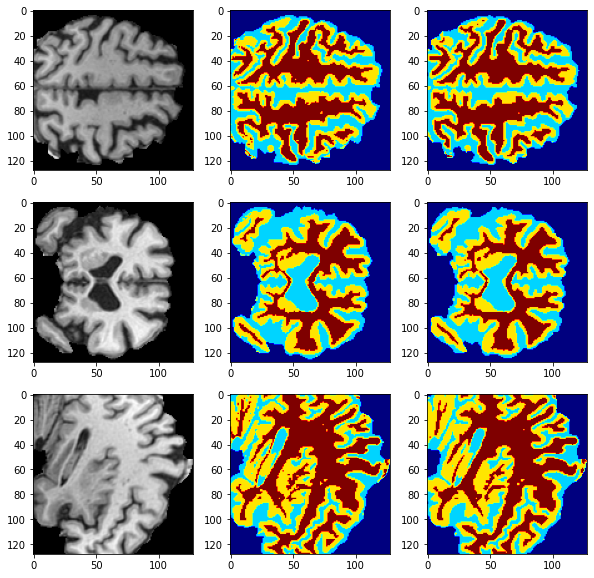

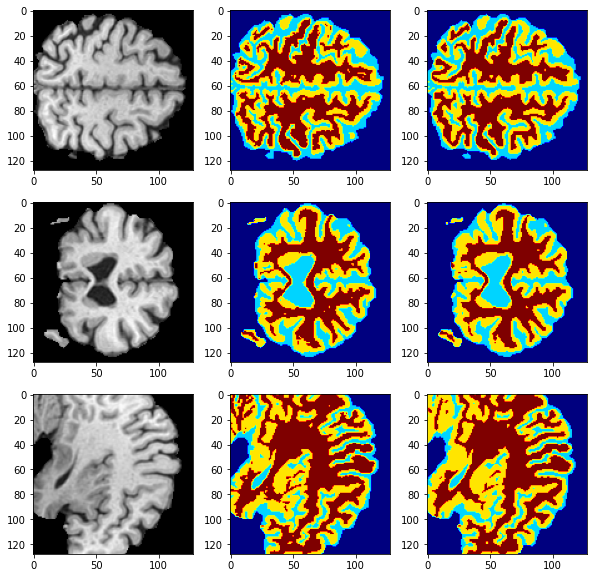

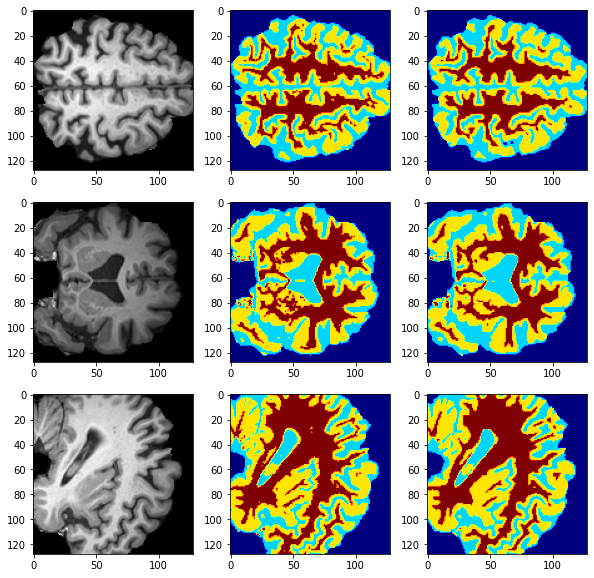

In [42]:
show_test_accuracy_2(nums=1, model=model, dl_test=dl_val, batch_size=5, 
                       device=torch.device("cuda" if torch.cuda.is_available() else "cpu"))

In [9]:
lst = 'sub-ADNI002S0295_ses-M72_T1w', 'sub-ADNI002S0413_ses-M96_T1w', 'sub-ADNI002S1155_ses-M96_T1w', 'sub-ADNI002S1280_ses-M96_T1w', 'sub-ADNI002S2043_ses-M12_T1w', 'sub-ADNI002S4171_ses-M12_T1w', 'sub-ADNI002S4225_ses-M84_T1w', 'sub-ADNI003S0908_ses-M84_T1w', 'sub-ADNI003S4081_ses-M24_T1w', 'sub-ADNI003S4555_ses-M24_T1w'

In [8]:
hc = "002S0295"
dem = "009S1354"

In [9]:

def get_segment_outs(arr, values_to_change={1, 2, 3}, threshold=0.5):

    arr=arr.copy()
    act_values = np.random.choice(list(values_to_change), arr.shape)
    change_mask = np.random.rand(*arr.shape) < threshold
    mask = np.isin(arr, list(values_to_change)) & change_mask  
    arr[mask] = act_values[mask]  
    return arr

In [13]:
df.loc[df.filenames.str.contains("009S1354")]

,AGE,PTEDUCAT,APOE4,ADAS11,MMSE,ABETA_bl,TAU_bl,PTAU_bl,M,filenames,...,DX_bl_CN,DX_bl_EMCI,DX_bl_LMCI,DX_bl_SMC,PTGENDER_Female,PTGENDER_Male,PTGENDER_nan,PTMARRY_Divorced,PTMARRY_Married,PTMARRY_Never married
470,58.9,16,2.0,29.0,18,543.5,477.9,46.54,6,sub-ADNI009S1354_ses-M06_T1w,...,0,0,0,0,1,0,0,0,1,0


In [14]:
plt.imshow(vol[3][:,20,:], cmap="jet")

NameError: name 'vol' is not defined

In [12]:
df = pd.read_csv("cleaned_df_5_31.csv")

In [15]:
df_volume = pd.read_csv("df_volume.csv")

In [28]:
df_volume.columns = ["Idx", "filenames", "Volume_BG", "Volume_CSF", "Volume_GM", "Volume_WM"]

In [3]:
df.columns

Index(['AGE', 'PTEDUCAT', 'APOE4', 'ADAS11', 'MMSE', 'ABETA_bl', 'TAU_bl',
       'PTAU_bl', 'M', 'filenames', 'DX_bl_AD', 'DX_bl_CN', 'DX_bl_EMCI',
       'DX_bl_LMCI', 'DX_bl_SMC', 'PTGENDER_Female', 'PTGENDER_Male',
       'PTGENDER_nan', 'PTMARRY_Divorced', 'PTMARRY_Married',
       'PTMARRY_Never married'],
      dtype='object')

In [9]:
dfg = df.groupby(["AGE", "PTEDUCAT"]).agg({"ADAS11":"first"}).reset_index()

In [34]:
df_final = pd.merge(df, df_volume, on="filenames", how="inner").drop(columns=["Idx"])

In [35]:
df_final.to_csv("Healthy_with_volume.csv")

In [33]:
df.loc[df.filenames.str.contains("S0006")]

,AGE,PTEDUCAT,APOE4,ADAS11,MMSE,ABETA_bl,TAU_bl,PTAU_bl,M,filenames,...,DX_bl_CN,DX_bl_EMCI,DX_bl_LMCI,DX_bl_SMC,PTGENDER_Female,PTGENDER_Male,PTGENDER_nan,PTMARRY_Divorced,PTMARRY_Married,PTMARRY_Never married
0,80.4,13,0.0,19.00,21,1002.240126,286.524536,27.657809,6,sub-ADNI100S0006_ses-M06_T1w,...,0,0,1,0,1,0,0,0,1,0
1,80.4,13,0.0,18.67,26,1002.240126,286.524536,27.657809,12,sub-ADNI100S0006_ses-M12_T1w,...,0,0,1,0,1,0,0,0,1,0
2,80.4,13,0.0,11.33,24,1002.240126,286.524536,27.657809,18,sub-ADNI100S0006_ses-M18_T1w,...,0,0,1,0,1,0,0,0,1,0
3,80.4,13,0.0,17.67,22,1002.240126,286.524536,27.657809,36,sub-ADNI100S0006_ses-M36_T1w,...,0,0,1,0,1,0,0,0,1,0
732,80.4,13,0.0,14.67,26,1002.240126,286.524536,27.657809,24,sub-ADNI100S0006_ses-M24_T1w,...,0,0,1,0,1,0,0,0,1,0


In [6]:
df_h60 = df.loc[(df.ADAS11<=18)]

In [11]:
filenames = df_h60.filenames

NameError: name 'df_h60' is not defined

In [6]:
target_path = '/media/rajlab/sachin_data_1/userdata/daren/target/target_files/'
input_path = '/media/rajlab/sachin_data_1/userdata/daren/mri/'

In [7]:
# new_target = "sub-ADNI023S4115_ses-M84_T1w"

In [8]:
# target = nib.load(target_path + new_target + "_seg.nii").get_fdata()

In [9]:
from collections import Counter, defaultdict

In [10]:
raw_file = "sub-ADNI100S0006_ses-M18_T1w"

In [11]:
dementia_file = "sub-ADNI018S0057_ses-M18_T1w"

In [11]:
out = np.load(target_path + "extracted21.npy")

In [28]:
inp1 = np.load(input_path + "extracted21.npy")

FileNotFoundError: [Errno 2] No such file or directory: '/media/rajlab/sachin_data_1/userdata/daren/mri/extracted21.npy'

In [12]:
dementia_out = np.argmax(out[6], axis=0)

In [22]:
dementia_out.shape

(128, 128, 128)

In [29]:
dementia_out[100]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2

In [48]:
mri_data.shape

(182, 218, 182)

In [15]:
from tqdm import tqdm

## OcclusionMaps

In [4]:
from unet3d_lightning_tabular import LitURNet3d
from nilearn import plotting, image

In [5]:
target_path = '/media/rajlab/sachin_data_1/userdata/daren/target/target_files/'
input_path = '/media/rajlab/sachin_data_1/userdata/daren/mri/'
raw_file = "sub-ADNI100S0006_ses-M18_T1w"
target = nib.load(target_path + raw_file + "_seg.nii").get_fdata()
inp = nib.load(input_path + raw_file + ".nii.gz").get_fdata()

In [21]:
218-128

90

In [21]:
inp_r = np.array([[inp[27:27+128, 45:45+128, 27:27+128]]])

In [23]:
inp_r.mean()

384229.9307700007

In [58]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = LitURNet3d.load_from_checkpoint(PATH_TO_MODEL, precision=16)
model = model.to(device)
model.eval()

# Load 3D MRI data
# For demonstration, let's create a sample 3D array (replace this with your actual data)
# mri_data = np.random.rand(1, 1, 128, 128, 128)  # Example shape (batch, channels, depth, height, width)
mri_data = inp_r

# Convert MRI data to a PyTorch tensor and move it to the GPU
mri_tensor = torch.tensor(mri_data, dtype=torch.float32).to(device)

# Function to perform occlusion and get the model's prediction
def get_occlusion_map(data, model, patch_size=5):
    occlusion_map = np.zeros(data.shape[2:])  # Ignore batch and channel dimensions
    data = data.clone()  # Clone the input tensor to avoid in-place modifications
    for x in tqdm(range(0, data.shape[2], patch_size)):
        for y in range(0, data.shape[3], patch_size):
            for z in range(0, data.shape[4], patch_size):
                # Create a copy of the original data
                data_occluded = data.clone()
                # Occlude the patch
                data_occluded[:, :, x:x+patch_size, y:y+patch_size, z:z+patch_size] = 0
                # Get the prediction for the occluded data
                with torch.no_grad():
                    prediction = model(data_occluded, extract_features=False)
                # Assuming prediction is a tensor, get the mean impact
                if isinstance(prediction, tuple):
                    prediction = prediction[0]  # If model returns a tuple, take the first element
                occlusion_map[x:x+patch_size, y:y+patch_size, z:z+patch_size] = prediction.mean().item()
    return occlusion_map

# Get the occlusion map
occlusion_map = get_occlusion_map(mri_tensor, model, patch_size=5)

# # Move occlusion_map back to CPU for visualization
# occlusion_map = occlusion_map.cpu().numpy()

# # Visualize the occlusion map
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')

# x, y, z = np.indices(occlusion_map.shape)
# ax.voxels(x, y, z, occlusion_map > np.mean(occlusion_map), facecolors='blue', edgecolors='gray')

# ax.set_xlabel('X axis')
# ax.set_ylabel('Y axis')
# ax.set_zlabel('Z axis')
# plt.title('3D Occlusion Map')

# plt.show()


Using device: cuda


100%|█████████████████████████| 26/26 [34:05<00:00, 78.68s/it]


In [24]:
occlusion_map.shape

(128, 128, 128)

In [60]:
occlusion_map[0, 0]

array([12409480., 12409480., 12409480., 12409480., 12409480., 12409480.,
       12409480., 12409480., 12409480., 12409480., 12409480., 12409480.,
       12409480., 12409480., 12409480., 12409480., 12409480., 12409480.,
       12409480., 12409480., 12409480., 12409480., 12409480., 12409480.,
       12409480., 12409480., 12409480., 12409480., 12409480., 12409480.,
       12409480., 12409480., 12409480., 12409480., 12409480., 12409480.,
       12409480., 12409480., 12409480., 12409480., 12409480., 12409480.,
       12409480., 12409480., 12409480., 12409480., 12409480., 12409480.,
       12409480., 12409480., 12409480., 12409480., 12409480., 12409480.,
       12409480., 12409480., 12409480., 12409480., 12409480., 12409480.,
       12409480., 12409480., 12409480., 12409480., 12409480., 12409480.,
       12409480., 12409480., 12409480., 12409480., 12409480., 12409480.,
       12409480., 12409480., 12409480., 12409480., 12409480., 12409480.,
       12409480., 12409480., 12409480., 12409480., 

In [61]:
save_map = (occlusion_map - 12409480)/12409480

In [63]:
save_map[0,25]

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -8.05835539e-06, -8.05835539e-06, -8.05835539e-06, -8.05835539e-06,
       -8.05835539e-06, -2.61090715e-05, -2.61090715e-05, -2.61090715e-05,
       -2.61090715e-05, -2.61090715e-05,  1.04758620e-05,  1.04758620e-05,
        1.04758620e-05,  1.04758620e-05,  1.04758620e-05,  7.47009544e-05,
        7.47009544e-05,  7.47009544e-05,  7.47009544e-05,  7.47009544e-05,
        2.72533579e-04,  2.72533579e-04,  2.72533579e-04,  2.72533579e-04,
        2.72533579e-04,  2.76643340e-04,  2.76643340e-04,  2.76643340e-04,
        2.76643340e-04,  2.76643340e-04,  1.84858673e-04,  1.84858673e-04,
        1.84858673e-04,  

In [17]:
y.shape

(128, 128, 128)

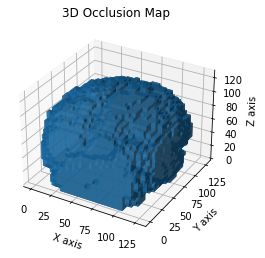

In [64]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Generating the x, y, z indices
x, y, z = np.indices(save_map.shape)

# Creating the voxel plot
# ax.voxels(occlusion_map > np.mean(occlusion_map), facecolors='blue', edgecolors='gray')
ax.voxels(save_map)

ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
plt.title('3D Occlusion Map')

plt.show()

In [9]:
occlusion_map = tt

In [10]:
occlusion_map.shape

(128, 128, 128)

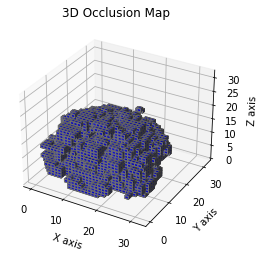

In [29]:
from scipy.ndimage import zoom

# Downsample the occlusion_map to a smaller size
downsample_factor = 0.5  # Adjust this factor to balance between speed and resolution
downsampled_occlusion_map = zoom(occlusion_map, downsample_factor)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Creating the voxel plot
ax.voxels(downsampled_occlusion_map > np.mean(downsampled_occlusion_map), facecolors='blue', edgecolors='gray', alpha=0.7)

ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
plt.title('3D Occlusion Map')

plt.show()


In [ ]:
occlusion_map 

In [34]:
save_map = (occlusion_map - 12409480)/12409480

# Calculate the padding widths for each dimension
pad_widths = (
    (27, 27),
    (45, 45),
    (27, 27)
)



# Pad the array to the desired shape
padded_inp = np.pad(inp_r[0][0], pad_widths, mode='constant', constant_values=0)
padded_occlusion_map = np.pad(occlusion_map, pad_widths, mode='constant', constant_values=0)

print("Original shape:", occlusion_map.shape)
print("Padded shape:", padded_occlusion_map.shape)

Original shape: (128, 128, 128)
Padded shape: (182, 218, 182)


In [142]:
occlusion_map = np.load("occlusion.npy")

save_map = (occlusion_map - 12409480)/12409480

# Calculate the padding widths for each dimension
pad_widths = (
    (27, 27),
    (45, 45),
    (27, 27)
)

save_map[save_map < 0] = 0
smean = save_map.mean()

# Pad the array to the desired shape
padded_save_map = np.pad(save_map, pad_widths, mode='constant', constant_values=0)

print("Original shape:", save_map.shape)
print("Padded shape:", padded_save_map.shape)

Original shape: (128, 128, 128)
Padded shape: (182, 218, 182)


In [143]:
mean_value = padded_save_map[padded_save_map > 0].mean()

zero_indices = np.argwhere(padded_save_map == 0)
for idx in zero_indices:
    if inp[tuple(idx)] != 0:
        padded_save_map[tuple(idx)] = np.random.choice(
        [6.446684309092726e-07
         ,1.6116710772731814e-06
         ,1.1442864648639588e-05
         ,2.4175066159097724e-07
         ,3.7068434777283173e-06])

#
padded_save_map[padded_save_map < 0] = 0.0016684875076588392

In [120]:
np.random.choice?

In [119]:
padded_save_map[tuple(idx)]

0.0

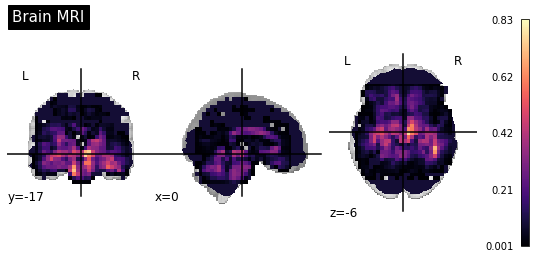

In [29]:
affine = np.eye(4)  # Identity matrix for affine (change if you have specific affine information)
brain_img = image.new_img_like(image.load_img('/home/madar/MNI152_T1_1mm_brain.nii.gz'), padded_save_map*100)
# brain_img = occlusion_map
# Plot the 3D image using nilearn
plotting.plot_stat_map(brain_img, display_mode='ortho', 
#                        cut_coords=(0, 0, 0), 
                       threshold=0.001, title='Brain MRI', cmap='magma')

# Show the plot
# plt.savefig("Occlusion.tif", dpi=600)

In [130]:
plotting.plot_stat_map?

In [141]:
save_map[91]

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 1.18941326e-04, 1.18941326e-04, 1.18941326e-04,
        1.18941326e-04, 1.18941326e-04, 2.76723924e-04, 2.76723924e-04,
        2.76723924e-04, 2.76723924e-04, 2.76723924e-04, 2.64233473e-04,
        2.64233473e-04, 2.64233473e-04, 2.64233473e-04, 2.64233473e-04,
        4.39986204e-05, 4.39986204e-05, 4.39986204e-05, 4.39986204e-05,
        4.39986204e-05, 1.90177187e-05, 1.90177187e-05, 1.90177187e-05,
        1.90177187e-05, 1.90177187e-05, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.53108752e-05,
        1.53108752e-05, 1.53108752e-05, 1.53108752e-05, 1.53108752e-05,
        4.45627053e-04, 4.45627053e-04, 4.45627053e-04, 4.45627053e-04,
        4.45627053e-04, 5.48290500e-04, 5.48290500e-04, 5.48290500e-04,
        5.48290500e-04, 5.48290500e-04, 3.30956656e-04, 3.30956656e-04,
        3.30956656e-04, 3.30956656e-04, 3.30956656e-04, 2.030705

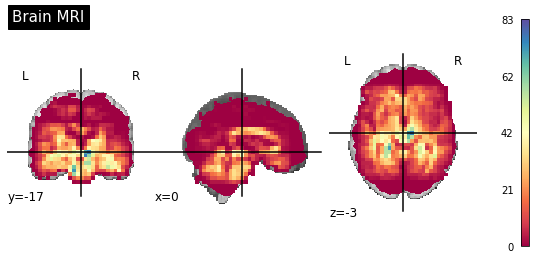

In [144]:
affine = np.eye(4)  # Identity matrix for affine (change if you have specific affine information)
brain_img = image.new_img_like(image.load_img('/home/madar/MNI152_T1_1mm_brain.nii.gz'), padded_save_map*10000)
# brain_img = occlusion_map
# Plot the 3D image using nilearn
plotting.plot_stat_map(brain_img, display_mode='ortho', 
                       dim=0,
#                        vmin=0.21,
#                        cut_coords=(0, 0, 0), 
                       threshold=0, title='Brain MRI', cmap='Spectral')


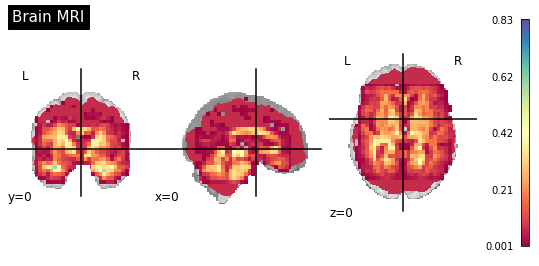

In [88]:
affine = np.eye(4)  # Identity matrix for affine (change if you have specific affine information)
brain_img = image.new_img_like(image.load_img('/home/madar/MNI152_T1_1mm_brain.nii.gz'), padded_save_map*100)
# brain_img = occlusion_map
# Plot the 3D image using nilearn
plotting.plot_stat_map(brain_img, display_mode='ortho', 
                       cut_coords=(0, 0, 0), 
                       threshold=0.001, title='Brain MRI', cmap='Spectral')


In [96]:
6.12840063e-04

0.000612840063

In [ ]:
6.48697609e-05

In [94]:
padded_save_map[100][20:60][:]

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.000000

In [81]:
save_map[save_map>0].min()

8.058355386365907e-08

In [109]:
from collections import Counter
value_counts = Counter(flattened_array)

# Get the top 10 most common values
top_10_values = value_counts.most_common(10)


In [115]:
np.random.choice([6.446684309092726e-07
 ,1.6116710772731814e-06
 ,1.1442864648639588e-05
 ,2.4175066159097724e-07
 ,3.7068434777283173e-06])

3.7068434777283173e-06

In [110]:
top_10_values

[(0.0, 938877),
 (6.446684309092726e-07, 1325),
 (1.6116710772731814e-06, 950),
 (1.1442864648639588e-05, 900),
 (2.4175066159097724e-07, 825),
 (3.7068434777283173e-06, 775),
 (4.673846124092226e-06, 750),
 (1.128169754091227e-06, 750),
 (3.223342154546363e-07, 725),
 (1.7728381850004995e-05, 625)]

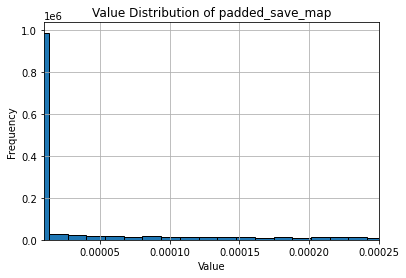

In [79]:
flattened_array = save_map.flatten()

# Plot the value distribution
plt.hist(flattened_array, bins='auto', edgecolor='black')
plt.title('Value Distribution of padded_save_map')
plt.xlabel('Value')
plt.xlim(0.00001,0.00025)
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

## Interpolation?

In [59]:
smoothed_array.shape

(182, 218, 182)

In [67]:
save_map.mean()

0.0005824676140971705

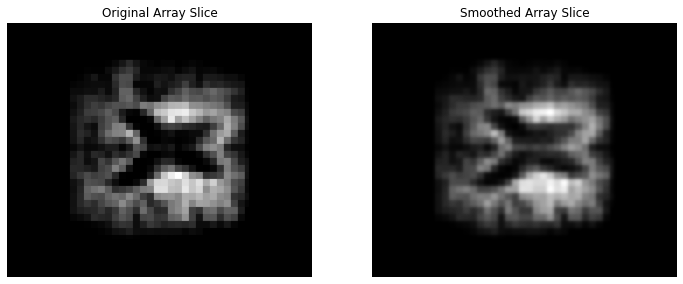

In [151]:
import numpy as np
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt

# Set all negative values to 0
padded_save_map[padded_save_map < 0] = 0

# Apply Gaussian filter for smoothing
sigma = 1  # Standard deviation for Gaussian kernel, adjust as needed
smoothed_array = gaussian_filter(padded_save_map, sigma=sigma)

# Plot a slice of the original and smoothed arrays for comparison
slice_idx = padded_save_map.shape[2] // 2  # Middle slice

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(padded_save_map[:, :, slice_idx], cmap='gray')
axes[0].set_title('Original Array Slice')
axes[0].axis('off')

axes[1].imshow(smoothed_array[:, :, slice_idx], cmap='gray')
axes[1].set_title('Smoothed Array Slice')
axes[1].axis('off')

plt.show()


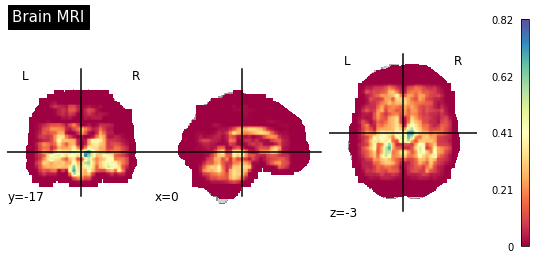

In [150]:
sigma = 1  # Standard deviation for Gaussian kernel, adjust as needed
smoothed_array = gaussian_filter(padded_save_map, sigma=sigma)

affine = np.eye(4)  # Identity matrix for affine (change if you have specific affine information)
brain_img = image.new_img_like(image.load_img('/home/madar/MNI152_T1_1mm_brain.nii.gz'), smoothed_array*100)
# brain_img = occlusion_map
# Plot the 3D image using nilearn
plotting.plot_stat_map(brain_img, display_mode='ortho', 
#                        cut_coords=(0, 0, 0), 
                       threshold=0.000, title='Brain MRI', cmap='Spectral')
# plt.savefig("Occlusion_2.tif", dpi=600)

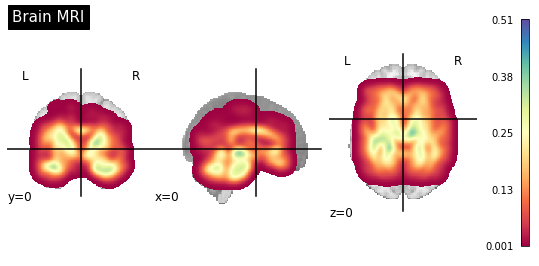

In [145]:
sigma = 4  # Standard deviation for Gaussian kernel, adjust as needed
smoothed_array = gaussian_filter(padded_save_map, sigma=sigma)

affine = np.eye(4)  # Identity matrix for affine (change if you have specific affine information)
brain_img = image.new_img_like(image.load_img('/home/madar/MNI152_T1_1mm_brain.nii.gz'), smoothed_array*100)
# brain_img = occlusion_map
# Plot the 3D image using nilearn
plotting.plot_stat_map(brain_img, display_mode='ortho', 
                       cut_coords=(0, 0, 0), 
                       threshold=0.001, title='Brain MRI', cmap='Spectral')

In [16]:
padded_save_map.shape

(182, 218, 182)

In [8]:
np.save("occlusion_normalized.npy", padded_save_map)

In [19]:
type(occlusion_map)

numpy.ndarray

In [95]:
np.save("occlusion.npy", occlusion_map)

In [6]:
tt = np.load("occlusion.npy")

In [7]:
tt.min()

12388592.0

In [69]:
plotting.plot_stat_map?

In [73]:
padded_save_map = padded_save_map*100

In [80]:
np.max?

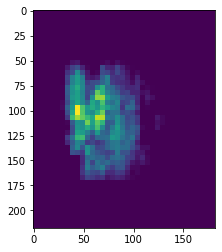

In [17]:
plt.imshow(np.max(padded_save_map,axis=0))

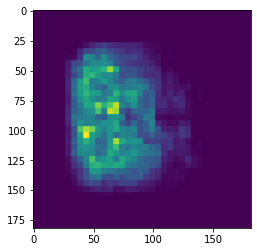

In [87]:
plt.imshow(np.max(padded_save_map,axis=1))

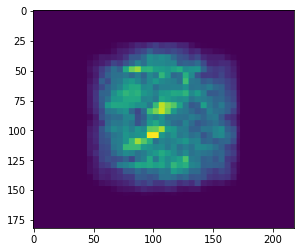

In [56]:
plt.imshow(np.max(padded_save_map,axis=2))

In [69]:
inp.shape

(182, 218, 182)

In [45]:
padded_inp[80][120]

array([      0.      ,       0.      ,       0.      ,       0.      ,
             0.      ,       0.      ,       0.      ,       0.      ,
             0.      ,       0.      ,       0.      ,       0.      ,
             0.      ,       0.      ,       0.      ,       0.      ,
             0.      ,       0.      ,       0.      ,       0.      ,
             0.      ,       0.      ,       0.      ,       0.      ,
             0.      ,       0.      ,       0.      ,       0.      ,
             0.      ,       0.      ,       0.      ,       0.      ,
             0.      ,       0.      ,       0.      ,       0.      ,
             0.      ,       0.      ,       0.      ,       0.      ,
             0.      ,       0.      ,       0.      ,  271680.71875 ,
        197071.75    ,  227727.96875 ,  273156.53125 ,  259176.921875,
        240200.296875,  297339.75    ,  461799.9375  ,  606843.5625  ,
        619822.5     ,  477682.25    ,  292679.90625 ,  189813.421875,
      

In [59]:
plotting.plot_stat_map?

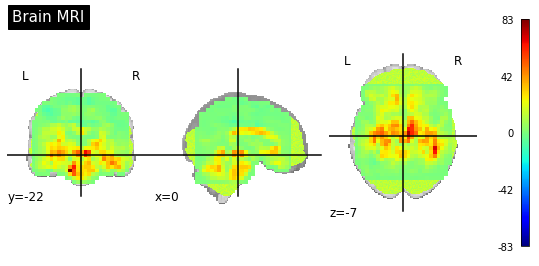

In [82]:
affine = np.eye(4)  # Identity matrix for affine (change if you have specific affine information)
brain_img = image.new_img_like(image.load_img('/home/madar/MNI152_T1_1mm_brain.nii.gz'), padded_save_map*10000)
# brain_img = occlusion_map
# Plot the 3D image using nilearn
plotting.plot_stat_map(brain_img, display_mode='ortho', 
#                        cut_coords=(0, 0, 0), 
                       threshold=0.001, title='Brain MRI', cmap='jet')

# Show the plot
plt.show()

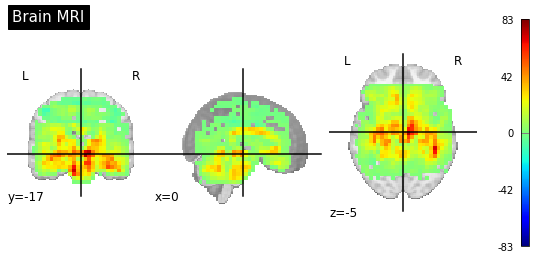

In [67]:
affine = np.eye(4)  # Identity matrix for affine (change if you have specific affine information)
brain_img = image.new_img_like(image.load_img('/home/madar/MNI152_T1_1mm_brain.nii.gz'), padded_save_map*10000)
# brain_img = occlusion_map
# Plot the 3D image using nilearn
plotting.plot_stat_map(brain_img, display_mode='ortho', 
#                        cut_coords=(0, 0, 0), 
                       threshold=0.5, title='Brain MRI', cmap='jet')

# Show the plot
plt.show()

/home/madar/miniconda3/lib/python3.8/site-packages/nilearn/plotting/displays/_slicers.py:308: UserWarning: empty mask
  ims = self._map_show(img, type="imshow", threshold=threshold, **kwargs)


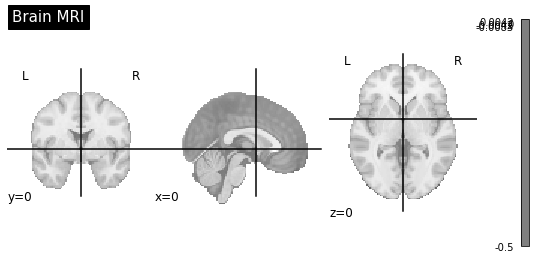

In [48]:
affine = np.eye(4)  # Identity matrix for affine (change if you have specific affine information)
brain_img = image.new_img_like(image.load_img('/home/madar/MNI152_T1_1mm_brain.nii.gz'), save_map)
# brain_img = occlusion_map
# Plot the 3D image using nilearn
plotting.plot_stat_map(brain_img, display_mode='ortho', cut_coords=(0, 0, 0), threshold=0.5, title='Brain MRI', cmap='jet')

# Show the plot
plt.show()

In [ ]:
inp_r[0][0]

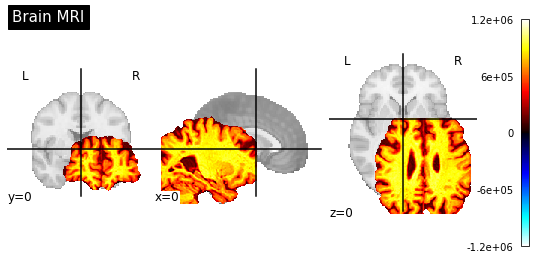

In [51]:
affine = np.eye(4)  # Identity matrix for affine (change if you have specific affine information)
brain_img = image.new_img_like(image.load_img('/home/madar/MNI152_T1_1mm_brain.nii.gz'), inp_r[0][0])
# brain_img = occlusion_map
# Plot the 3D image using nilearn
plotting.plot_stat_map(brain_img, display_mode='ortho', cut_coords=(0, 0, 0), threshold=0.5, title='Brain MRI')

# Show the plot
plt.show()

In [52]:
inp.shape

(182, 218, 182)

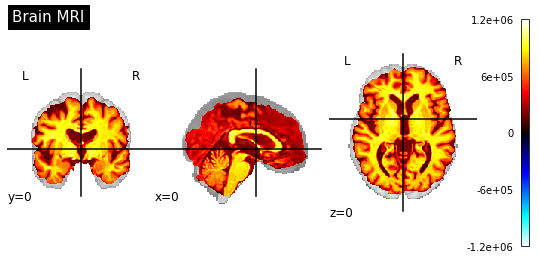

In [56]:
affine = np.eye(4)  # Identity matrix for affine (change if you have specific affine information)
brain_img = image.new_img_like(image.load_img('/home/madar/MNI152_T1_1mm_brain.nii.gz'), inp)
# brain_img = occlusion_map
# Plot the 3D image using nilearn
plotting.plot_stat_map(brain_img, display_mode='ortho', cut_coords=(0, 0, 0), threshold=0.5, title='Brain MRI')

# Show the plot
plt.show()

In [29]:
target = nib.load(target_path + raw_file + "_seg.nii").get_fdata()
inp = nib.load(input_path + raw_file + ".nii.gz").get_fdata()

In [30]:
inp2, target2 = nib.load(input_path + dementia_file + ".nii.gz").get_fdata(), \
nib.load(target_path + dementia_file + "_seg.nii").get_fdata()

In [25]:
def plot_imshow(inp, target, out1, out2, filename):
    fig, ax = plt.subplots(4, 3, figsize=(9, 12))
    ax[0][0].imshow(inp[100,:,:], cmap="gray",label="")
    ax[0][1].imshow(inp[:,100,:], cmap="gray",label="")
    ax[0][2].imshow(inp[:,:,100], cmap="gray",label="")

    ax[1][0].imshow(target[100,:,:], cmap="jet",label="")
    ax[1][1].imshow(target[:,100,:], cmap="jet",label="")
    ax[1][2].imshow(target[:,:,100], cmap="jet",label="")
    
    ax[2][0].imshow(out1[100,:,:], cmap="jet",label="")
    ax[2][1].imshow(out1[:,100,:], cmap="jet",label="")
    ax[2][2].imshow(out1[:,:,100], cmap="jet",label="")
    

    ax[3][0].imshow(out2[100,:,:], cmap="jet",label="")
    ax[3][1].imshow(out2[:,100,:], cmap="jet",label="")
    ax[3][2].imshow(out2[:,:,100], cmap="jet",label="")
    
    
    plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    
    fig.tight_layout()
    fig.savefig(f"{filename}.png", dpi=600)

In [26]:
tout1 = get_segment_outs(target2, threshold=0.0025)
tout2 = get_segment_outs(target2, threshold=0.0035)

test1 = get_segment_outs(target, threshold=0.0025)
test2 = get_segment_outs(target, threshold=0.0035)

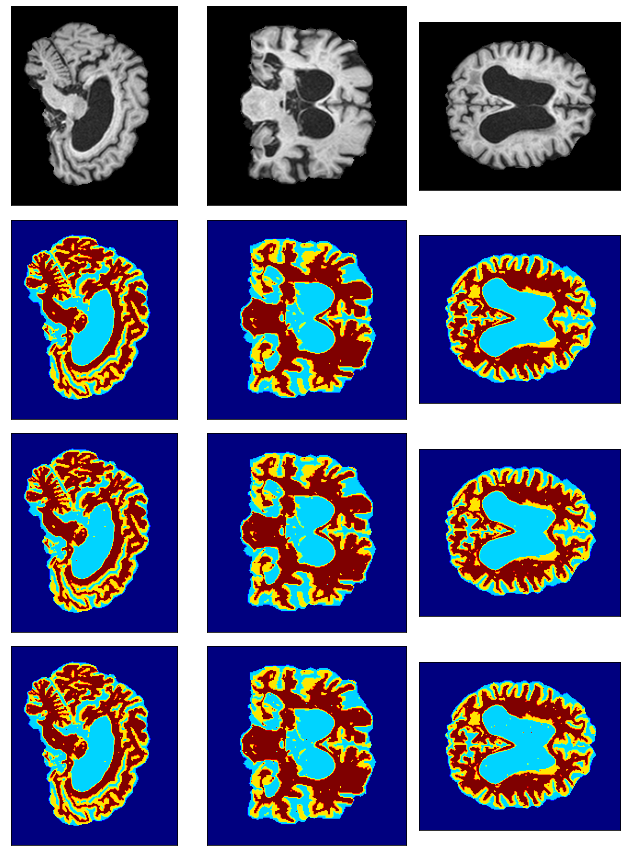

In [27]:
plot_imshow(inp2, target2, tout1, tout2, 'AD2')

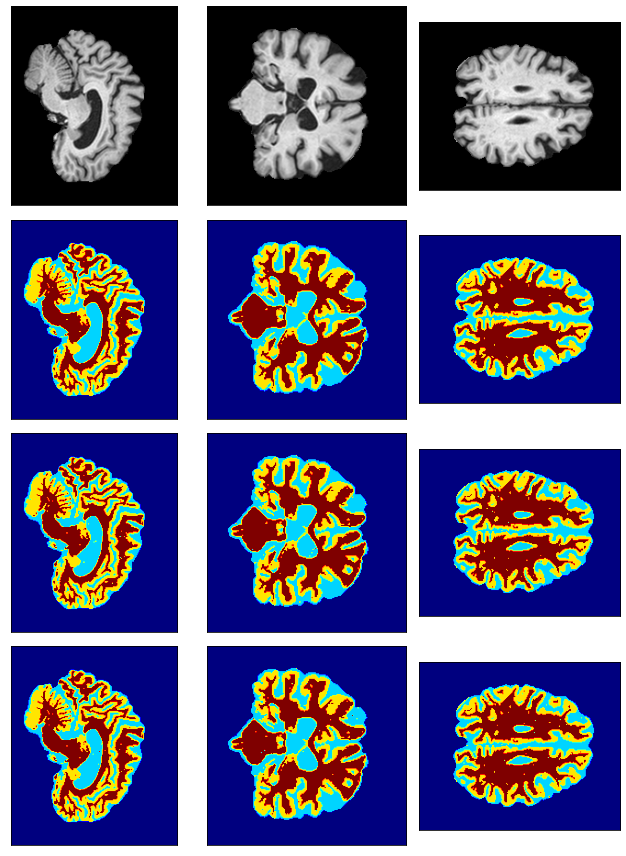

In [40]:
plot_imshow(inp, target, test1, test2, 'HC2')

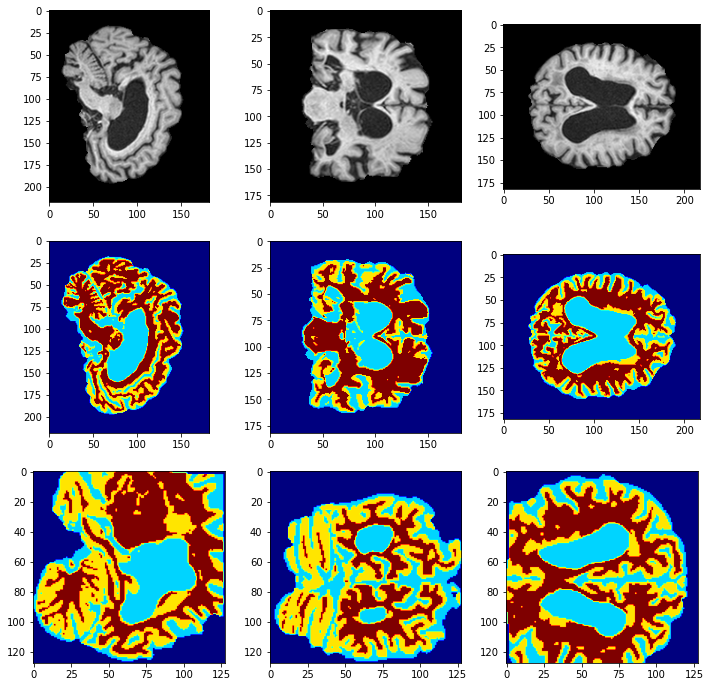

In [38]:
plot_imshow(inp2, target2, dementia_out)

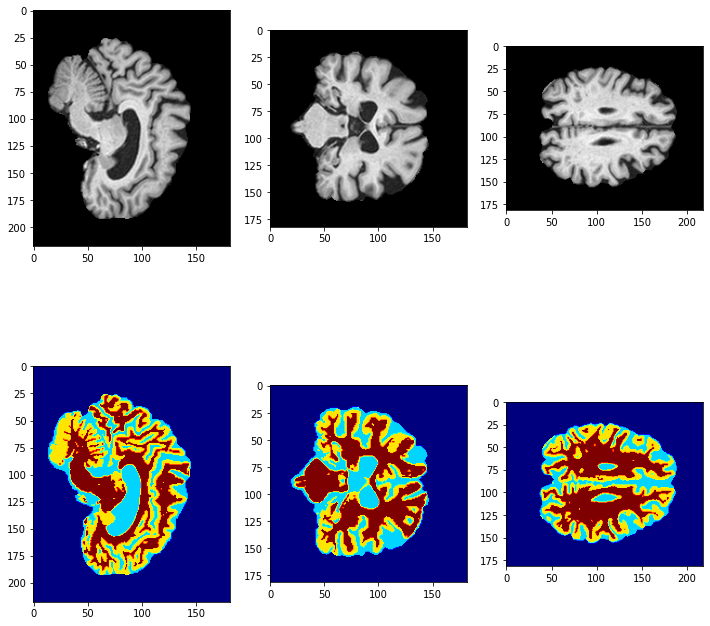

In [55]:
plot_imshow(inp, target)

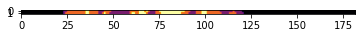

In [26]:
fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(target[100,50:52,:], cmap='inferno',label="")

In [ ]:
deepblue 1 green 2 yellow 3

In [59]:
target[120,50:52,:]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 1., 1., 1., 2., 2., 2., 2., 2., 2., 1.,
        1., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 1., 1., 1., 1.,
        1., 2., 2., 2., 3., 3., 3., 3., 2., 2., 2., 3., 3., 3., 3., 3.,
        3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 2., 2.,
        1., 1., 2., 2., 2., 3., 3., 2., 2., 2., 2., 2., 2., 2., 2., 3.,
        3., 3., 3., 3., 3., 3., 3., 2., 2., 1., 1., 1., 2., 2., 2., 2.,
        2., 2., 2., 2., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 1., 1., 1., 2., 2., 2., 2., 2., 2., 2., 1.,
        1., 1., 2., 2., 2., 2.,

In [12]:
d = defaultdict(list)
for file in tqdm(filenames):
    d["filenames"].append(file)
    target = nib.load(target_path + file + "_seg.nii").get_fdata()
    counts = Counter(np.array(target).flatten())
    d["V0"].append(counts[0.0])
    d["V1"].append(counts[1.0])
    d["V2"].append(counts[2.0])
    d["V3"].append(counts[3.0])


100%|███████████████████████████████████████| 1292/1292 [22:27<00:00,  1.04s/it]


In [13]:
df_volume = pd.DataFrame.from_dict(d)
df_volume.to_csv("df_volume.csv")

In [14]:
df_volume

,filenames,V0,V1,V2,V3
0,sub-ADNI100S0006_ses-M18_T1w,5735705,457451,564470,463406
1,sub-ADNI100S0006_ses-M36_T1w,5724835,451025,567195,477977
2,sub-ADNI100S0015_ses-M12_T1w,5516088,480107,663098,561739
3,sub-ADNI100S0015_ses-M36_T1w,5527012,490488,644225,559307
4,sub-ADNI100S5280_ses-M24_T1w,5348006,508828,753604,610594
...,...,...,...,...,...
1287,sub-ADNI023S4115_ses-M84_T1w,5646838,407156,608137,558901
1288,sub-ADNI007S4272_ses-M84_T1w,5892742,372165,478644,477481
1289,sub-ADNI068S4431_ses-M84_T1w,5665136,507831,558786,489279
1290,sub-ADNI116S4855_ses-M72_T1w,5771633,442753,509732,496914
